# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.

У нас несколько задач. 

Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import plot_tree
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

import warnings

# отключаем предупреждения
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.impute")

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Загрузка данных

In [2]:
# загружаем файл в виде датафрейма и задаем переменную
d_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
d_train.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [3]:
d_test = pd.read_csv('/datasets/test_features.csv')
d_test.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [4]:
d_test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
d_test_target.head(10)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


### Вывод

Данные соответсвую описанию, у нас есть тренировочная выборка и тестовые.

## Предобработка данных

### Тренировочный датасет

In [5]:
d_train.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


In [6]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
d_train['id'].duplicated().sum()

0

In [8]:
d_train['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [9]:
d_train[d_train['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [10]:
d_train['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [11]:
d_train[d_train['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [12]:
d_train['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [13]:
d_train['employment_years'].unique()

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

In [14]:
d_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [15]:
d_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [16]:
d_train['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4])

In [17]:
d_train['salary'].unique()

array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200])

In [18]:
d_train['job_satisfaction_rate'].unique()

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

In [19]:
d_train.duplicated().sum()

0

### Тестовый датасет

In [20]:
d_test.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [21]:
d_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [22]:
d_test['id'].duplicated().sum()

0

In [23]:
d_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [24]:
d_test[d_test['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [25]:
d_test[d_test['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [26]:
d_test['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [27]:
d_test['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [28]:
d_test['employment_years'].unique()

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10])

In [29]:
d_test['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [30]:
d_test['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [31]:
d_test['supervisor_evaluation'].unique()

array([5, 4, 3, 1, 2])

In [32]:
d_test['salary'].unique()

array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
       36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
       18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
       58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
       38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
       72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
       94800, 82800, 80400, 87600, 86400, 96000, 78000, 75600, 73200,
       84000, 88800, 92400])

In [33]:
d_test.duplicated().sum()

0

### Целевой признак тестовой выборки

In [34]:
d_test_target.head(10)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


In [35]:
d_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [36]:
d_test_target['id'].duplicated().sum()

0

In [37]:
d_test_target['job_satisfaction_rate'].unique()

array([0.74, 0.75, 0.6 , 0.72, 0.08, 0.76, 0.64, 0.38, 0.14, 0.59, 0.91,
       0.78, 0.7 , 0.79, 0.34, 0.81, 0.23, 0.4 , 0.58, 0.77, 0.68, 0.24,
       0.42, 0.69, 0.47, 0.35, 0.71, 0.83, 0.61, 0.65, 0.37, 0.45, 0.63,
       0.82, 0.16, 0.89, 0.28, 0.32, 0.88, 0.36, 0.33, 0.31, 0.27, 0.73,
       0.53, 0.26, 0.57, 0.2 , 1.  , 0.56, 0.67, 0.19, 0.52, 0.43, 0.12,
       0.11, 0.21, 0.13, 0.49, 0.22, 0.86, 0.46, 0.41, 0.48, 0.29, 0.87,
       0.66, 0.8 , 0.55, 0.5 , 0.51, 0.62, 0.85, 0.84, 0.15, 0.39, 0.25,
       0.9 , 0.07, 0.1 , 0.92, 0.3 , 0.44, 0.18, 0.93, 0.54, 0.96, 0.09,
       0.99, 0.17, 0.95, 0.06, 0.94, 0.03, 0.98, 0.97, 0.04, 0.05])

### Вывод

Сменила типы данных на категориальные, обнаружены пропуски в столбцах 'dept', 'level' и 'workload' (в тестовой) они будут заполнены позже в пайплайне.

## Исследовательский анализ данных

In [38]:
# создадим функции для отображения графиков
def plot_distribution(df, column, bins=30, title=None):
    """
    Функция рисует гистограмму и boxplot для столбца с колличественными данными.
    """
    
    # создаем фигуру с двумя графиками
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # гистограмма
    sns.histplot(df[column], bins=bins, ax=axes[0], kde=True)
    axes[0].set_title(f'Распределение данных "{title}"')
    axes[0].set_xlabel(title)
    axes[0].set_ylabel('Частота')

    # boxplot
    sns.boxplot(x=df[column], ax=axes[1])
    axes[1].set_title(f'Boxplot "{title}"')
    axes[1].set_xlabel(title)

    plt.tight_layout()
    plt.show();

def plot_categorical(df, column, title=None):
    """
    Функция рисует pie chart для столбца с категориальными данными.
    """
    
    # считаем количество для каждой категории
    counts = df[column].value_counts()
    
    plt.figure(figsize=(7, 7))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')  # чтобы круг был кругом, а не овалом
    plt.show();

def plot_bar_chart(df, column, title, xlab):
    """
    Строит столбчатую диаграмму распределения.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show();

### Тренировочный датасет

In [39]:
d_train['dept'].value_counts(normalize=True)

sales         0.378568
technology    0.216825
purchasing    0.152729
marketing     0.137707
hr            0.114171
Name: dept, dtype: float64

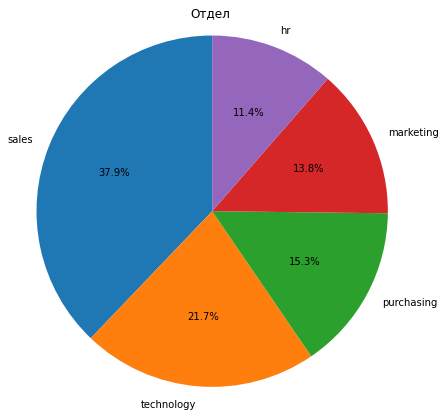

In [40]:
plot_categorical(d_train, 'dept', 'Отдел')

In [41]:
d_train['level'].value_counts(normalize=True)

junior    0.473974
middle    0.436436
sinior    0.089590
Name: level, dtype: float64

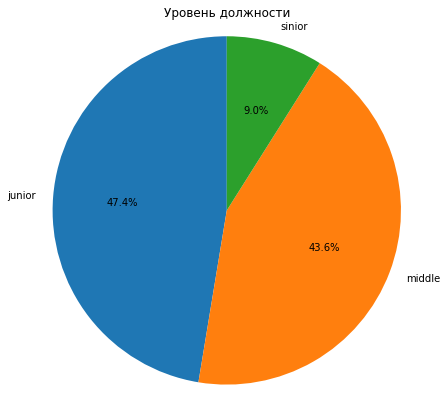

In [42]:
plot_categorical(d_train, 'level', 'Уровень должности')

In [43]:
d_train['workload'].value_counts(normalize=True)

medium    0.5165
low       0.3000
high      0.1835
Name: workload, dtype: float64

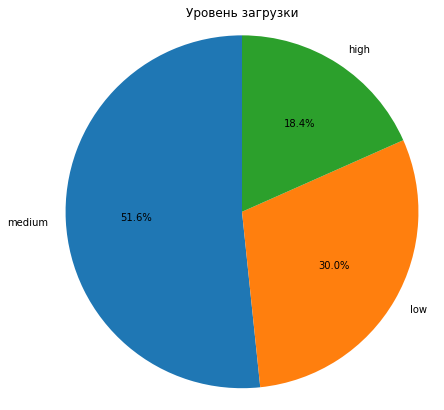

In [44]:
plot_categorical(d_train, 'workload', 'Уровень загрузки')

In [45]:
d_train['last_year_promo'].value_counts(normalize=True)

no     0.97
yes    0.03
Name: last_year_promo, dtype: float64

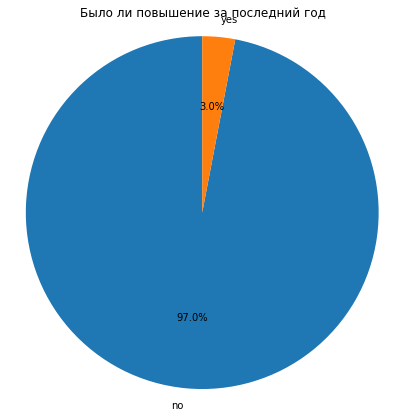

In [46]:
plot_categorical(d_train, 'last_year_promo', 'Было ли повышение за последний год')

In [47]:
d_train['last_year_violations'].value_counts(normalize=True)

no     0.86025
yes    0.13975
Name: last_year_violations, dtype: float64

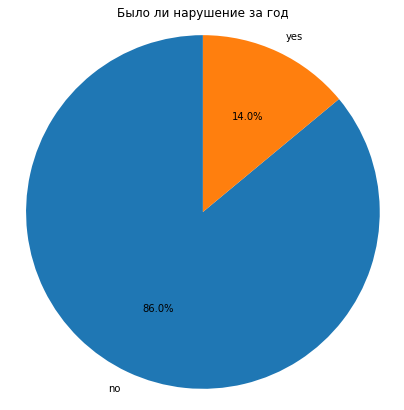

In [48]:
plot_categorical(d_train, 'last_year_violations', 'Было ли нарушение за год')

In [49]:
d_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


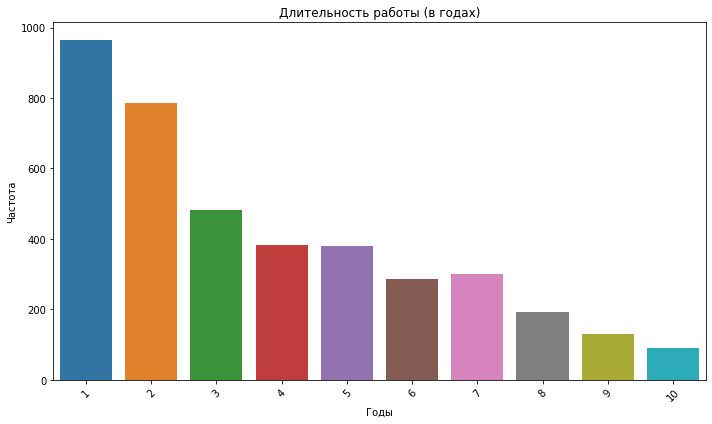

In [50]:
plot_bar_chart(d_train, 'employment_years', 'Длительность работы (в годах)', 'Годы')

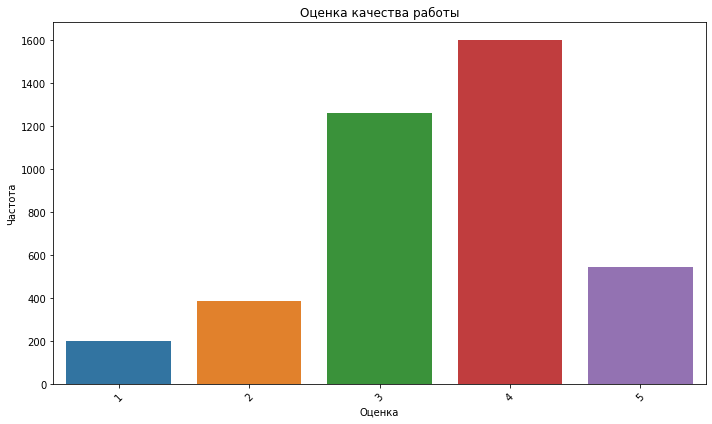

In [51]:
plot_bar_chart(d_train, 'supervisor_evaluation', 'Оценка качества работы', 'Оценка')

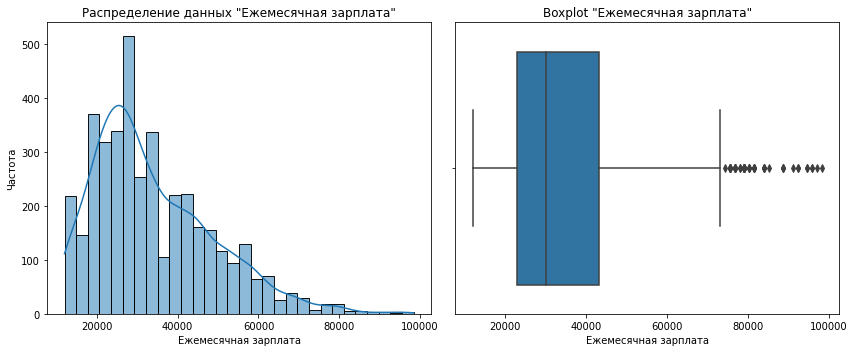

In [52]:
plot_distribution(d_train, 'salary', bins=30, title='Ежемесячная зарплата')

In [53]:
d_train[d_train['salary'] > 75000]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
45,538347,technology,sinior,high,3,no,no,1,84000,0.21
141,128304,marketing,sinior,high,7,no,no,3,80400,0.48
196,486576,marketing,sinior,high,9,no,no,4,76800,0.66
360,405345,marketing,sinior,high,7,no,no,2,81600,0.58
427,399126,sales,sinior,high,2,no,no,2,76800,0.26
1040,301946,hr,sinior,high,7,no,no,5,75600,0.75
1203,493024,technology,sinior,high,10,no,no,4,79200,0.64
1241,148024,technology,sinior,high,4,no,no,4,94800,0.67
1491,796799,marketing,sinior,high,4,no,no,3,79200,0.25
1543,775511,sales,sinior,high,5,no,yes,3,75600,0.17


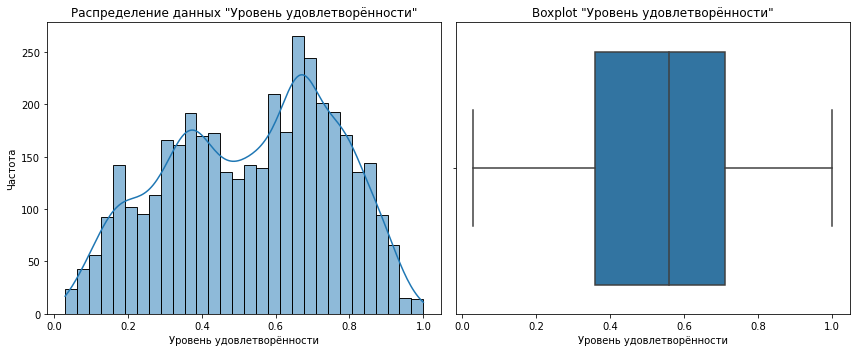

In [54]:
plot_distribution(d_train, 'job_satisfaction_rate', bins=30, title='Уровень удовлетворённости')

### Тестовый датасет

In [55]:
d_test['dept'].value_counts(normalize=True)

sales         0.381882
technology    0.227728
marketing     0.139640
purchasing    0.136637
hr            0.113614
              0.000501
Name: dept, dtype: float64

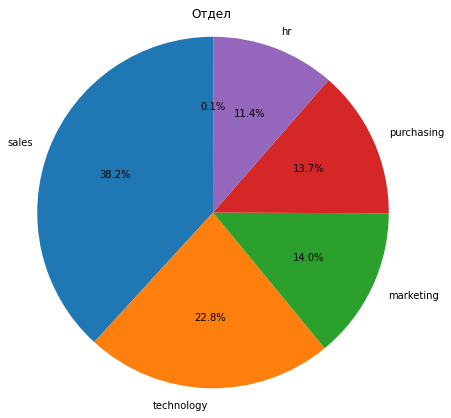

In [56]:
plot_categorical(d_test, 'dept', 'Отдел')

In [57]:
d_test['level'].value_counts(normalize=True)

junior    0.487244
middle    0.427214
sinior    0.085543
Name: level, dtype: float64

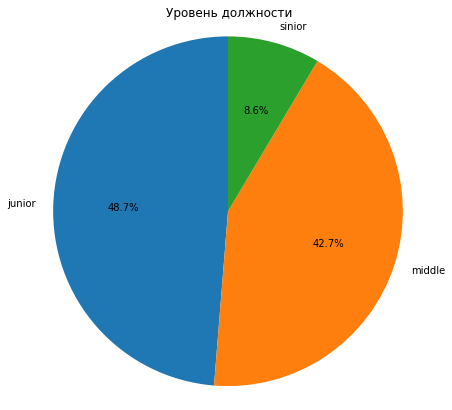

In [58]:
plot_categorical(d_test, 'level', 'Уровень должности')

In [59]:
d_test['workload'].value_counts(normalize=True)

medium    0.5215
low       0.2965
high      0.1815
          0.0005
Name: workload, dtype: float64

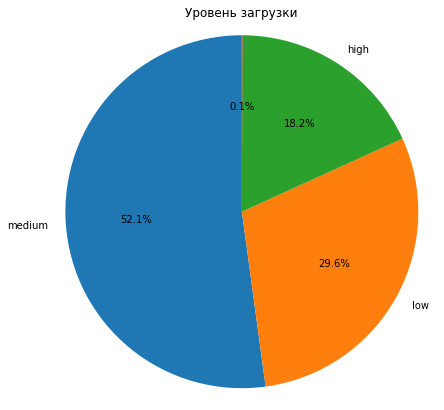

In [60]:
plot_categorical(d_test, 'workload', 'Уровень загрузки')

In [61]:
d_test['last_year_promo'].value_counts(normalize=True)

no     0.9685
yes    0.0315
Name: last_year_promo, dtype: float64

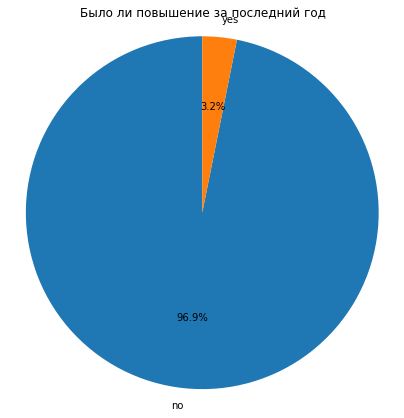

In [62]:
plot_categorical(d_test, 'last_year_promo', 'Было ли повышение за последний год')

In [63]:
d_test['last_year_violations'].value_counts(normalize=True)

no     0.869
yes    0.131
Name: last_year_violations, dtype: float64

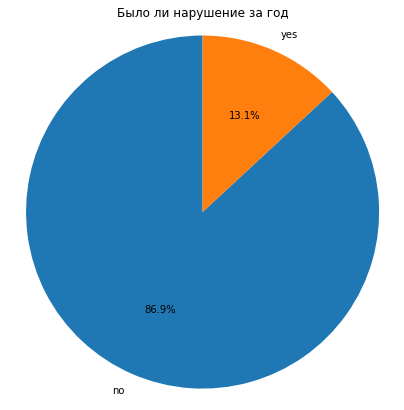

In [64]:
plot_categorical(d_test, 'last_year_violations', 'Было ли нарушение за год')

In [65]:
d_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


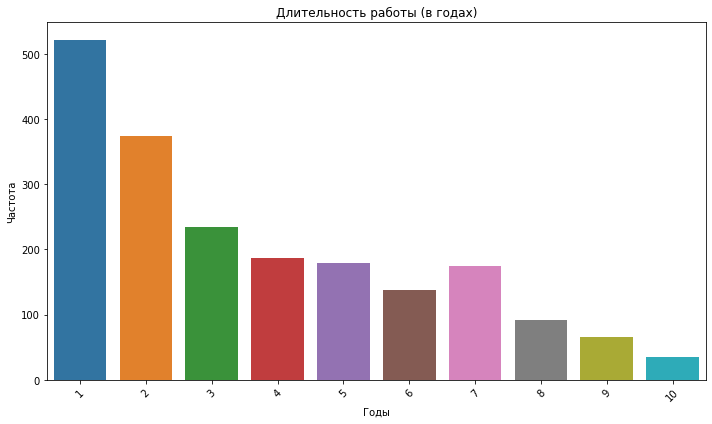

In [66]:
plot_bar_chart(d_test, 'employment_years', 'Длительность работы (в годах)', 'Годы')

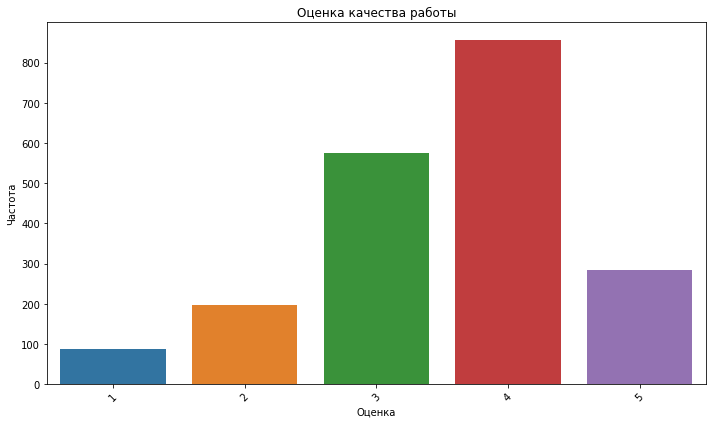

In [67]:
plot_bar_chart(d_test, 'supervisor_evaluation', 'Оценка качества работы', 'Оценка')

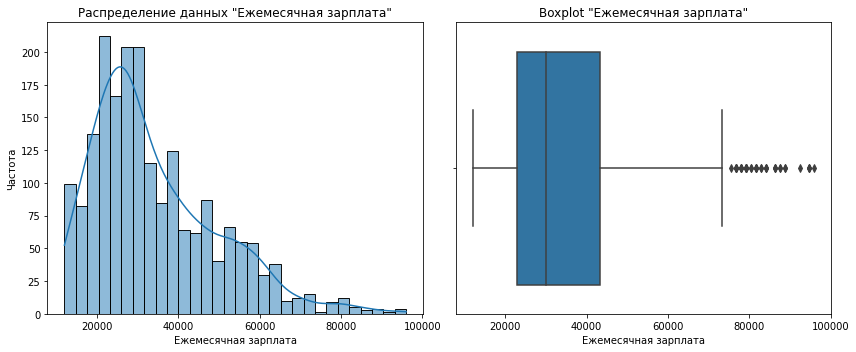

In [68]:
plot_distribution(d_test, 'salary', bins=30, title='Ежемесячная зарплата')

### Целевой признак тестовой выборки

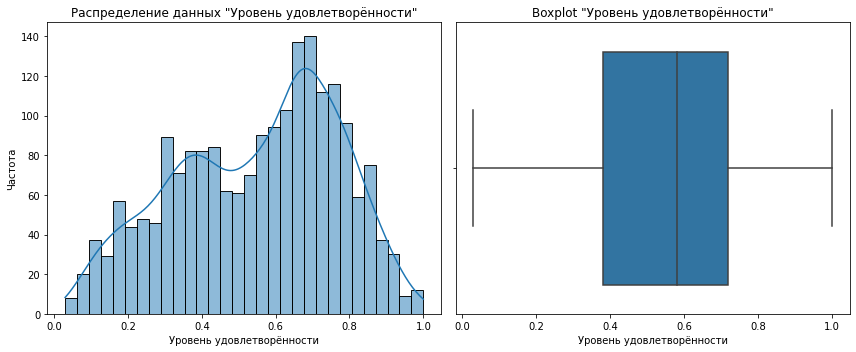

In [69]:
plot_distribution(d_test_target, 'job_satisfaction_rate', bins=30, title='Уровень удовлетворённости')

### Вывод

Компания имеет молодой штат с преобладанием junior и middle сотрудников, работающих в основном в отделах продаж и технологии. Уровень удовлетворённости и качество работы находятся на приемлемом уровне, но есть пространство для улучшения. Система повышения неодназначна (возможно раз оценки руководителей низкие, то и повышений не было, однако, стоит обратить внимание, возможно с какими-то сотрудниками есть смысл расстаться), а нагрузка распределена равномерно. Для дальнейшего развития компании важно сфокусироваться на развитии молодых специалистов, поддержке сотрудников с низкими оценками и обеспечении справедливости в системе повышения.

### Изучение зависимостей тренировочной выборки

In [70]:
def plot_scatter_by_category(df, num_features, category, target, title, ncols=3):
    """
    функция строит scatterplot между целевым признаком и числовыми признаками,
    с цветовым разделением по категориальному признаку.
    """
    
    nplots = len(num_features)
    nrows = (nplots // ncols) + (1 if nplots % ncols > 0 else 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
    axes = axes.flatten() 

    # Цикл по каждому числовому признаку
    for i, feature in enumerate(num_features):
        sns.scatterplot(
            ax=axes[i],
            data=d_train_corr,
            x=feature,
            y=target,
            hue=category,
            alpha=0.7,
            edgecolor=None,
            legend=(i == 0)
        )
        axes[i].set_title(f'{target.replace("_", " ").title()} и {feature.replace("_", " ").title()}')
        axes[i].set_xlabel(feature.replace('_', ' ').title())
        axes[i].grid(True)

        if axes[i].get_legend() is not None:
            axes[i].get_legend().remove()

    # Убираем пустые подграфики
    for i in range(nplots, len(axes)):
        fig.delaxes(axes[i])        

    # Создаём общую легенду справа
    # Используем первый график, чтобы получить handles и labels
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title=category.replace('_', ' ').title(),
        loc='center left',  # Размещение справа по центру
        bbox_to_anchor=(0.98, 0.5),  # Точное позиционирование
        frameon=True,
        fontsize=10,
        title_fontsize=12
    )
    
    # Общий заголовок
    plt.suptitle(title, fontsize=14, y=1)
    plt.tight_layout()
    plt.show()

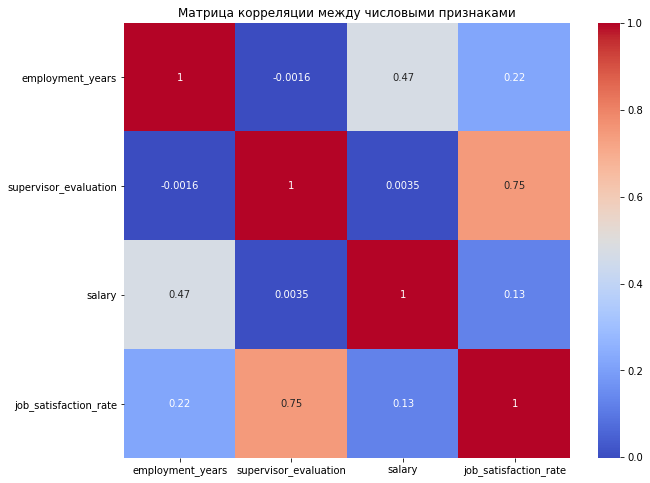

In [71]:
d_train_corr = d_train.drop(columns=['id'])
plt.figure(figsize=(10, 8))
sns.heatmap(d_train_corr.corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title('Матрица корреляции между числовыми признаками')
plt.show()

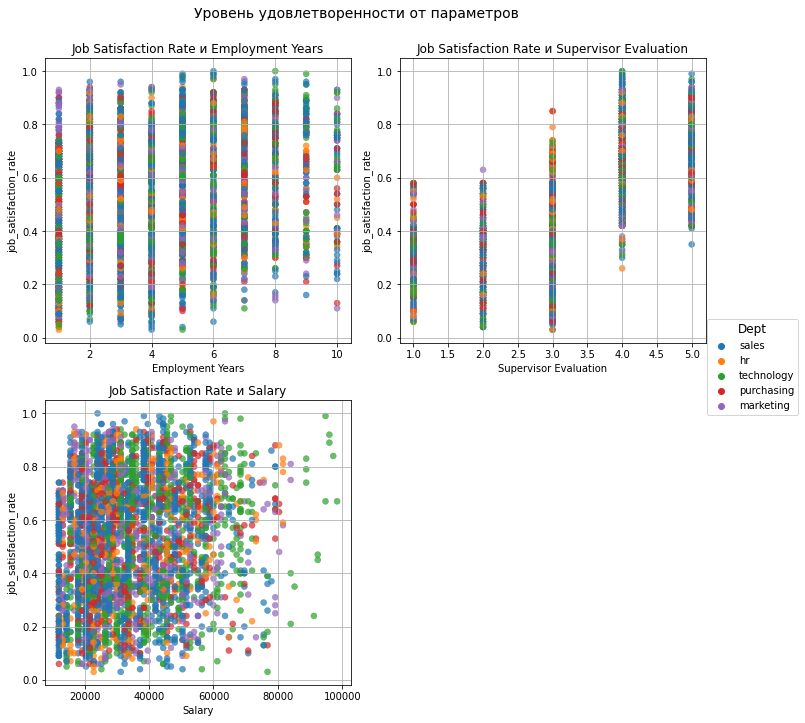

In [72]:
col_num_plot = ['employment_years', 'supervisor_evaluation', 'salary']
plot_scatter_by_category(
    df=d_train_corr,
    num_features=col_num_plot,
    category='dept',
    target='job_satisfaction_rate',
    title='Уровень удовлетворенности от параметров',
    ncols=2
)

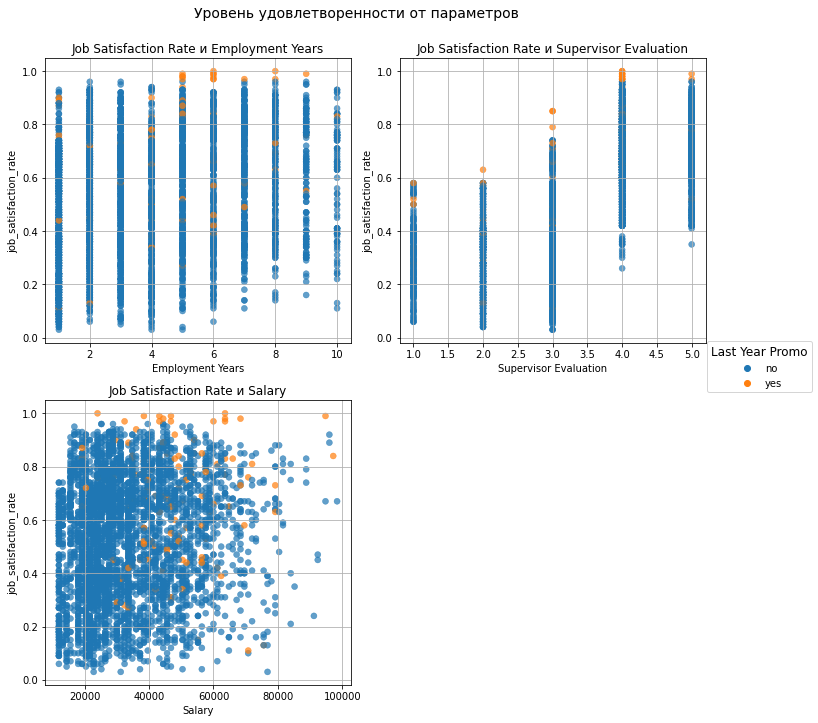

In [73]:
plot_scatter_by_category(
    df=d_train_corr,
    num_features=col_num_plot,
    category='last_year_promo',
    target='job_satisfaction_rate',
    title='Уровень удовлетворенности от параметров',
    ncols=2
)

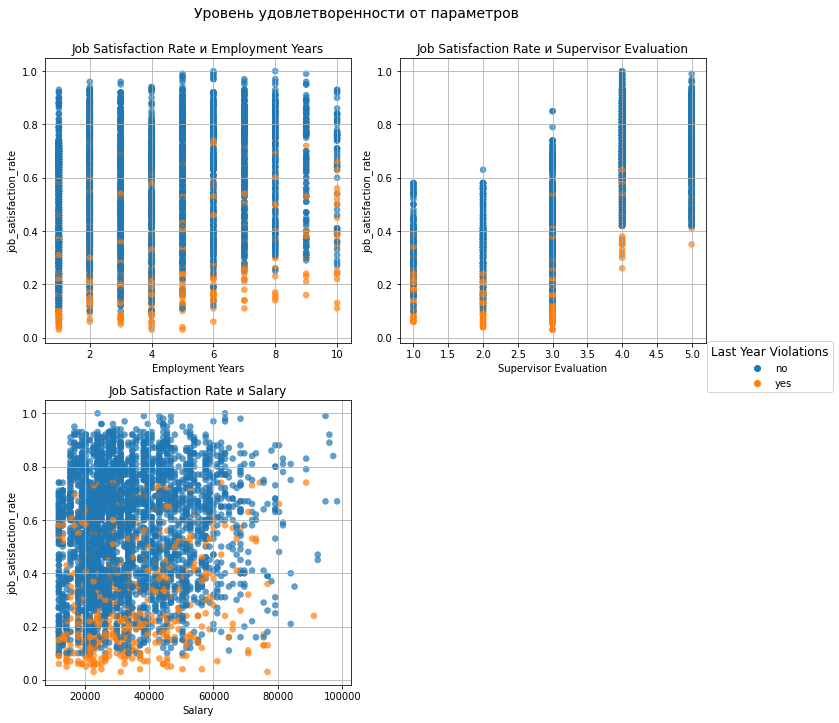

In [74]:
plot_scatter_by_category(
    df=d_train_corr,
    num_features=col_num_plot,
    category='last_year_violations',
    target='job_satisfaction_rate',
    title='Уровень удовлетворенности от параметров',
    ncols=2
)

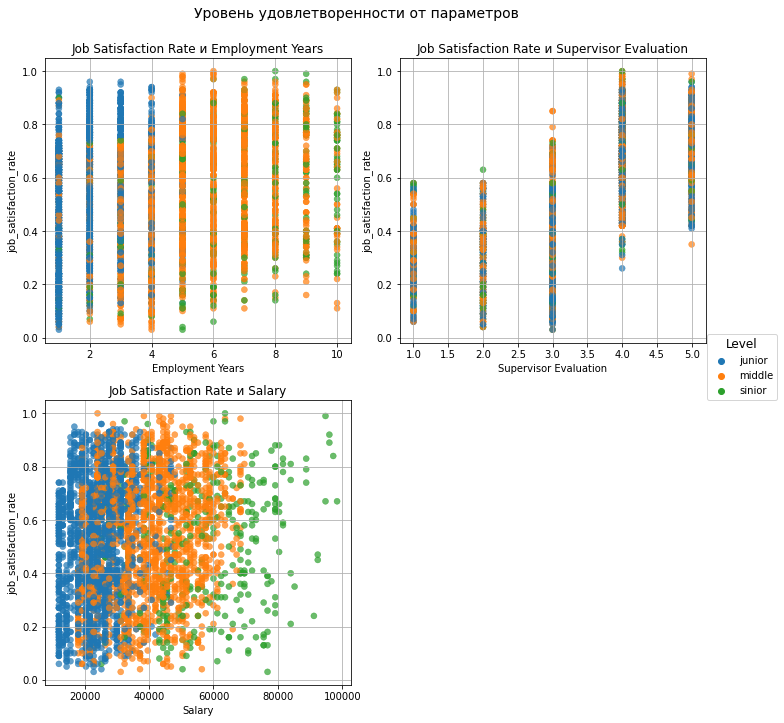

In [75]:
plot_scatter_by_category(
    df=d_train_corr,
    num_features=col_num_plot,
    category='level',
    target='job_satisfaction_rate',
    title='Уровень удовлетворенности от параметров',
    ncols=2
)

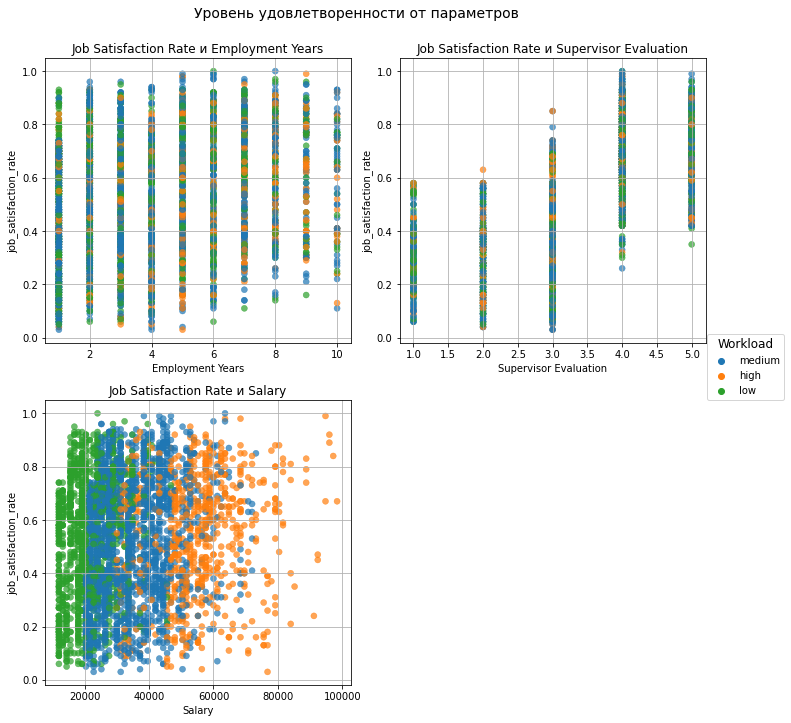

In [76]:
plot_scatter_by_category(
    df=d_train_corr,
    num_features=col_num_plot,
    category='workload',
    target='job_satisfaction_rate',
    title='Уровень удовлетворенности от параметров',
    ncols=2
)

### Вывод

Матрица корреляций показала следующие основные связи:
- Сильная положительная корреляция между Supervisor Evaluation (оценка руководителем) и Job Satisfaction Rate (оценка удовлектворенности), коэффициент 0.75. Это указывает на то, что высокая оценка от руководителя существенно повышает удовлетворённость.
- Умеренная положительная корреляция между стажем работы и уровенем зарплаты, коэффициент 0.47. Сотрудники с большим стажем, как правило, получают большую зарплату (грейд завязан на опыте работы), но эта связь не является чёткой.

**Общий вывод**

Линейная связь частично присутствует (особенно между оценкой руководителем и удовлетворённостью), но данные содержат много нелинейностей и категориальных факторов. Линейная регрессия подойдёт как базовая модель, но лучше использовать дерево решений для более точного и адекватного прогноза.

## Подготовка данных и обучение моделей

In [77]:
# Рассчет нужной метрики
def smape(y_true, y_pred):
    """
    Метрика SMAPE.

    Параметры:
        y_true (array): Фактические значения целевой переменной.
        y_pred (array): Предсказанные значения целевой переменной.

    Результат:
        значение SMAPE, тип float.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    # Абсолютная разница
    diff = np.abs(y_true - y_pred)
    # Среднее из абсолютных значений
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    smape_parts = diff / denominator
    smape_value = np.mean(smape_parts) * 100
    
    return smape_value

smape_scorer = make_scorer(smape, greater_is_better=False)

# Функция для очистки пробелов
def clean_spaces(X):
    X = X.copy()
    object_cols = X.select_dtypes(include=['object']).columns
    for col in object_cols:
        X.loc[:, col] = X[col].str.strip().replace(r'^\s*$', np.nan, regex=True)
        
    return X

In [78]:
X_train = d_train.drop(columns=['id', 'job_satisfaction_rate'])
y_train = d_train['job_satisfaction_rate']

RANDOM_STATE = 42

col_ohe = ['dept']
col_ord = ['level', 'workload', 'last_year_promo', 'last_year_violations']
col_num = ['employment_years', 'supervisor_evaluation', 'salary']

In [79]:
# заполнение + OHE
ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# заполнение + ORD
ord_pipeline = Pipeline([
    (
        'imputer',
        SimpleImputer(strategy='most_frequent')
    ),
    (
        'ord',
        OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'sinior'],
                ['low', 'medium', 'high'],
                ['no', 'yes'],
                ['no', 'yes']
            ],
            handle_unknown='use_encoded_value',
            unknown_value=-1
    )),
    (
        'imputer_after_ord',
        SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])
ohe_pipeline, ord_pipeline

(Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                 ('ohe', OneHotEncoder(handle_unknown='ignore'))]),
 Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                 ('ord',
                  OrdinalEncoder(categories=[['junior', 'middle', 'sinior'],
                                             ['low', 'medium', 'high'],
                                             ['no', 'yes'], ['no', 'yes']],
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1)),
                 ('imputer_after_ord', SimpleImputer(strategy='most_frequent'))]))

In [80]:
# создаём препроцессор
preprocessor = ColumnTransformer([
    ('cat_ohe', ohe_pipeline, col_ohe),
    ('cat_ord', ord_pipeline, col_ord),
    ('num', RobustScaler(), col_num)
], remainder='drop')  # на всякий случай, если что-то осталось

preprocessor

ColumnTransformer(transformers=[('cat_ohe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['dept']),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'sinior'],
                                                                             ['low',
     

In [81]:
# пайплайн линейной регрессии
pipe_lr = Pipeline([
    ('clean_spaces', FunctionTransformer(clean_spaces)),
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_scores = cross_val_score(
    pipe_lr,
    X_train,
    y_train,
    cv=5,
    scoring=smape_scorer
)

-lr_scores

array([25.20147044, 25.75418493, 25.76145521, 25.18968366, 23.20324572])

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

У тебя 2 выборки: трейн и тест. Следовательно следует использовать механизм кросс-валидации.
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>



"Тестирование" (проверка метрики на тестовой выборке) для каждой модели - и избыточно и неверно. Нужно выбрать **самую лучшую модель** по результатам на кросс-валидации и "протестировать" только ее. 
    
Вымышленный пример: если возникает ситуация, что на кросс-валидации лучшая catboost, на тесте random forest, стоит ли нам взять random forest как результат? Нет, иначе тестирование теряет статус независимой проверки, и мы просто подгоняем результаты под тестовый набор, но на практике данные не будут ограничены рамками тестовой выборки, поэтому полагаться на произведенный таким образом выбор мы не можем.
</div>

In [82]:
# пайплайн дерева решений
pipe_dtr = Pipeline([
    ('clean_spaces', FunctionTransformer(clean_spaces)),
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

dtr_scores = cross_val_score(
    pipe_dtr,
    X_train,
    y_train,
    cv=5,
    scoring=smape_scorer
)

-dtr_scores

array([15.66133302, 15.28862127, 15.3164952 , 16.05651056, 13.99869707])

In [83]:
param_grid = {
    'regressor__max_depth': [3, 5, 7, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    pipe_dtr,
    param_grid,
    cv=3,
    scoring=smape_scorer,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
grid_search.best_params_, -grid_search.best_score_

({'regressor__max_depth': None,
  'regressor__min_samples_leaf': 4,
  'regressor__min_samples_split': 10},
 14.440042002893795)

In [84]:
d_test = d_test.sort_values(by='id').reset_index(drop=True)
d_test_target = d_test_target.sort_values(by='id').reset_index(drop=True)
d_test.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000
5,100710,hr,sinior,low,6,no,no,4,27600
6,100894,sales,middle,high,6,no,no,3,56400
7,102102,marketing,junior,medium,3,no,no,4,25200
8,102222,marketing,middle,medium,8,no,no,4,36000
9,102320,sales,middle,high,4,no,no,3,57600


In [85]:
d_test_target.head(10)

,id,job_satisfaction_rate
0,100298,0.80
1,100480,0.84
2,100503,0.79
3,100610,0.75
4,100692,0.69
5,100710,0.68
6,100894,0.49
7,102102,0.73
8,102222,0.66
9,102320,0.26


In [86]:
df_new = d_test.merge(d_test_target, on='id', how='inner')
df_new.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.80
1,100480,marketing,junior,low,4,no,no,4,16800,0.84
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,0.75
4,100692,sales,middle,high,6,no,no,4,48000,0.69


In [87]:
d_test_new = df_new.drop(columns=['id', 'job_satisfaction_rate'])
d_test_target_new = df_new['job_satisfaction_rate']

best_model = grid_search.best_estimator_

y_pred_best_test = best_model.predict(d_test_new)
smape_best_test = smape(d_test_target_new, y_pred_best_test)
smape_best_test

13.504786166285038

In [88]:
# проверим модель на адекватность
dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(d_test_new)
dummy_smape = smape(d_test_target_new, y_dummy_pred)
dummy_smape

38.21941812666904

### Вывод

На тренировочной выборке  показала себя лучше модель DecisionTreeRegressor и на тестовой выборке достигла критерия успеха (SMAPE: 13,5 ≤ 15). Линейная модель не может эффективно работать, т.к. слабая линейная связь в данных. Рекомендуется использовать best_model: DecisionTreeRegressor с параметрами:
- 'regressor__max_depth': None,
- 'regressor__min_samples_leaf': 4,
- 'regressor__min_samples_split': 10.

Если заполнить средним, метрика хуже, модель прошла адекватность.

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [89]:
q_train = pd.read_csv('/datasets/train_quit.csv')
q_train.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [90]:
q_test = pd.read_csv('/datasets/test_features.csv')
q_test.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [91]:
q_test_target = pd.read_csv('/datasets/test_target_quit.csv')
q_test_target.head(10)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


### Вывод

Данные соответсвуют описанию.

## Предобработка данных

### Тренировочная выборка

In [92]:
q_train.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


In [93]:
q_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [94]:
q_train.duplicated().sum()

0

In [95]:
q_train['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [96]:
q_train['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [97]:
q_train['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [98]:
q_train['employment_years'].unique()

array([ 2,  5,  1,  8,  4,  7,  3,  9,  6, 10])

In [99]:
q_train['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [100]:
q_train['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [101]:
q_train['supervisor_evaluation'].unique()

array([4, 1, 3, 5, 2])

In [102]:
q_train['salary'].unique()

array([54000, 27600, 37200, 24000, 25200, 18000, 44400, 19200, 45600,
       57600, 33600, 16800, 22800, 26400, 82800, 32400, 39600, 30000,
       46800, 12000, 15600, 58800, 60000, 66000, 21600, 38400, 62400,
       40800, 56400, 34800, 28800, 52800, 20400, 36000, 61200, 48000,
       43200, 73200, 31200, 78000, 64800, 72000, 94800, 96000, 63600,
       79200, 55200, 42000, 49200, 50400, 14400, 13200, 51600, 67200,
       88800, 68400, 69600, 70800, 84000, 81600, 87600, 75600, 91200,
       76800, 74400, 80400, 85200, 86400, 92400])

### Тестовая выборка

In [103]:
q_test.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


In [104]:
q_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [105]:
q_test.duplicated().sum()

0

In [106]:
q_test['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [107]:
q_test[q_test['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [108]:
q_test['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [109]:
q_test['workload'].unique()

array(['medium', 'low', 'high', ' '], dtype=object)

In [110]:
q_test[q_test['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [111]:
q_test['employment_years'].unique()

array([ 2,  1,  5,  6,  3,  9,  7,  4,  8, 10])

In [112]:
q_test['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [113]:
q_test['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [114]:
q_test['salary'].unique()

array([28800, 30000, 19200, 40800, 42000, 26400, 49200, 62400, 14400,
       36000, 33600, 44400, 27600, 12000, 64800, 20400, 34800, 15600,
       18000, 50400, 31200, 51600, 16800, 43200, 52800, 32400, 37200,
       58800, 24000, 21600, 48000, 45600, 25200, 63600, 61200, 56400,
       38400, 46800, 55200, 13200, 39600, 54000, 57600, 68400, 22800,
       72000, 81600, 60000, 66000, 67200, 70800, 76800, 79200, 69600,
       94800, 82800, 80400, 87600, 86400, 96000, 78000, 75600, 73200,
       84000, 88800, 92400])

In [115]:
q_test = q_test.sort_values(by='id').reset_index(drop=True)
q_test.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000
5,100710,hr,sinior,low,6,no,no,4,27600
6,100894,sales,middle,high,6,no,no,3,56400
7,102102,marketing,junior,medium,3,no,no,4,25200
8,102222,marketing,middle,medium,8,no,no,4,36000
9,102320,sales,middle,high,4,no,no,3,57600


### Целевой признак тестовой выборки

In [116]:
q_test_target.head(10)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


In [117]:
q_test_target = q_test_target.sort_values(by='id').reset_index(drop=True)
q_test_target.head(10)

,id,quit
0,100298,no
1,100480,no
2,100503,no
3,100610,no
4,100692,no
5,100710,no
6,100894,no
7,102102,no
8,102222,no
9,102320,no


In [118]:
q_test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [119]:
q_test_target.duplicated().sum()

0

In [120]:
q_test_target['quit'].unique()

array(['no', 'yes'], dtype=object)

### Вывод

Приведены типы столбцов в категориальные, обнаружены пропуски, заполнятся в пайплайне. Дубликатов нет.

## Исследовательский анализ данных

### Тренировочная выборка

In [121]:
q_train['dept'].value_counts(normalize=True)

sales         0.3595
technology    0.2320
purchasing    0.1470
marketing     0.1455
hr            0.1160
Name: dept, dtype: float64

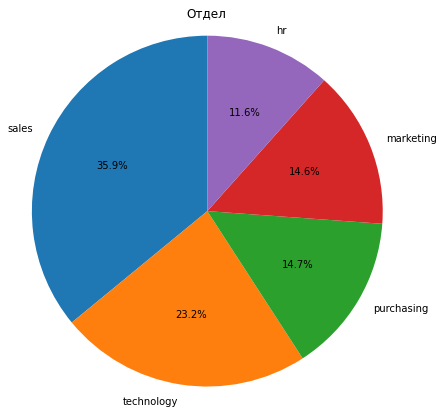

In [122]:
plot_categorical(q_train, 'dept', 'Отдел')

In [123]:
q_train['level'].value_counts(normalize=True)

junior    0.48725
middle    0.42350
sinior    0.08925
Name: level, dtype: float64

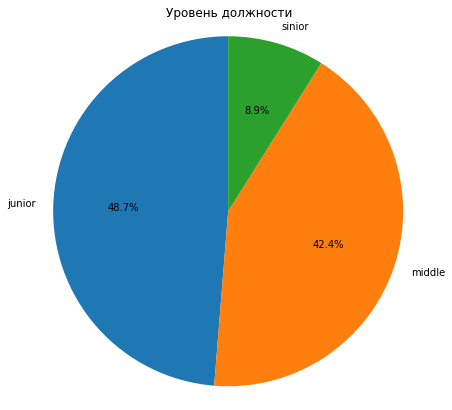

In [124]:
plot_categorical(q_train, 'level', 'Уровень должности')

In [125]:
q_train['workload'].value_counts(normalize=True)

medium    0.5295
low       0.3020
high      0.1685
Name: workload, dtype: float64

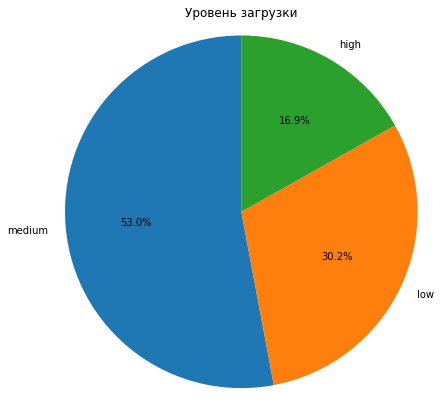

In [126]:
plot_categorical(q_train, 'workload', 'Уровень загрузки')

In [127]:
q_train['last_year_promo'].value_counts(normalize=True)

no     0.97175
yes    0.02825
Name: last_year_promo, dtype: float64

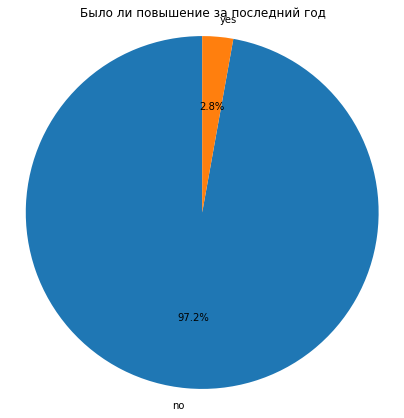

In [128]:
plot_categorical(q_train, 'last_year_promo', 'Было ли повышение за последний год')

In [129]:
q_train['last_year_violations'].value_counts(normalize=True)

no     0.86375
yes    0.13625
Name: last_year_violations, dtype: float64

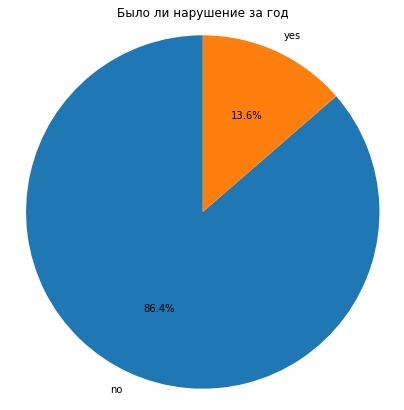

In [130]:
plot_categorical(q_train, 'last_year_violations', 'Было ли нарушение за год')

In [131]:
q_train['quit'].value_counts(normalize=True)

no     0.718
yes    0.282
Name: quit, dtype: float64

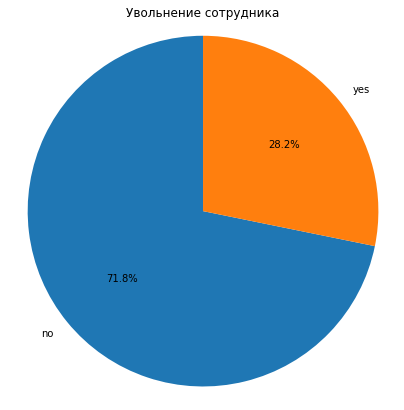

In [132]:
plot_categorical(q_train, 'quit', 'Увольнение сотрудника')

In [133]:
q_train.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


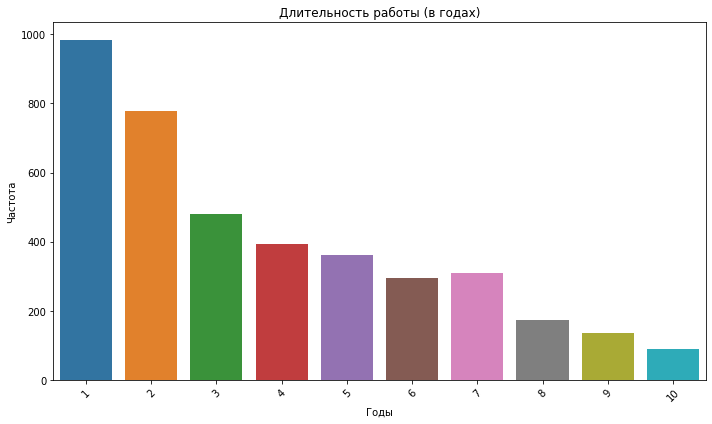

In [134]:
plot_bar_chart(q_train, 'employment_years', 'Длительность работы (в годах)', 'Годы')

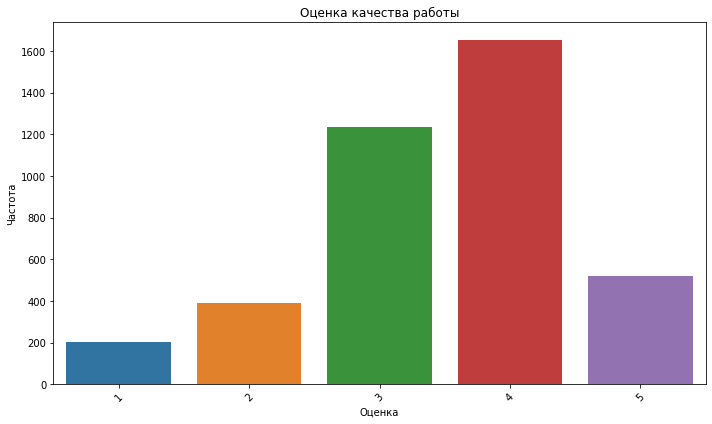

In [135]:
plot_bar_chart(q_train, 'supervisor_evaluation', 'Оценка качества работы', 'Оценка')

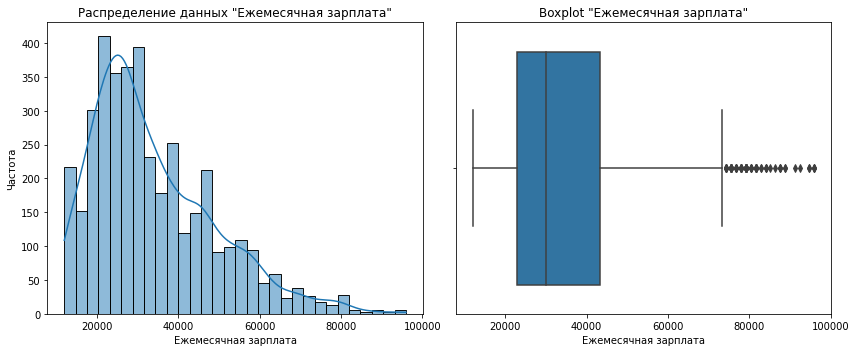

In [136]:
plot_distribution(q_train, 'salary', bins=30, title='Ежемесячная зарплата')

### Тестовая выборка

In [137]:
q_test['dept'].value_counts(normalize=True)

sales         0.381882
technology    0.227728
marketing     0.139640
purchasing    0.136637
hr            0.113614
              0.000501
Name: dept, dtype: float64

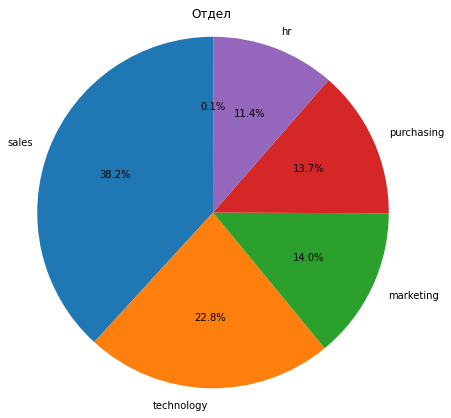

In [138]:
plot_categorical(q_test, 'dept', 'Отдел')

In [139]:
q_test['level'].value_counts(normalize=True)

junior    0.487244
middle    0.427214
sinior    0.085543
Name: level, dtype: float64

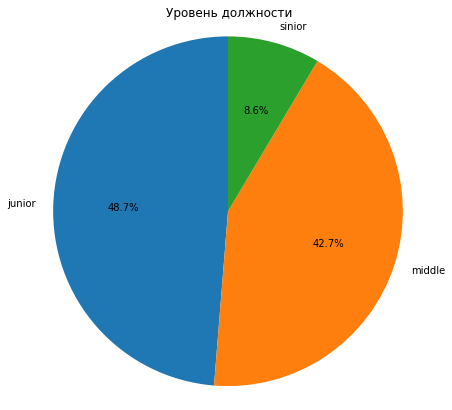

In [140]:
plot_categorical(q_test, 'level', 'Уровень должности')

In [141]:
q_test['workload'].value_counts(normalize=True)

medium    0.5215
low       0.2965
high      0.1815
          0.0005
Name: workload, dtype: float64

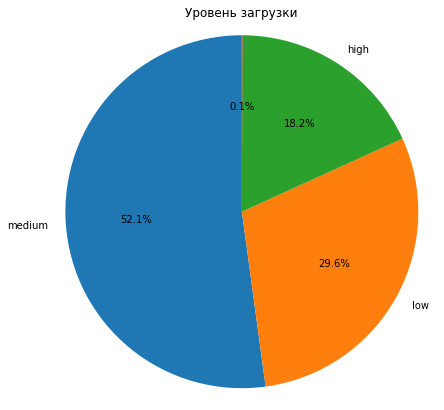

In [142]:
plot_categorical(q_test, 'workload', 'Уровень загрузки')

In [143]:
q_test['last_year_promo'].value_counts(normalize=True)

no     0.9685
yes    0.0315
Name: last_year_promo, dtype: float64

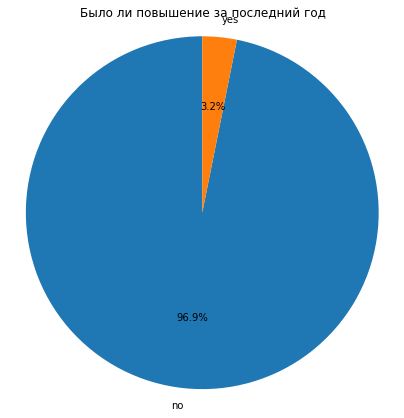

In [144]:
plot_categorical(q_test, 'last_year_promo', 'Было ли повышение за последний год')

In [145]:
q_test['last_year_violations'].value_counts(normalize=True)

no     0.869
yes    0.131
Name: last_year_violations, dtype: float64

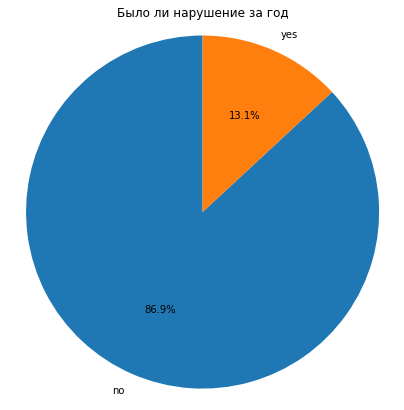

In [146]:
plot_categorical(q_test, 'last_year_violations', 'Было ли нарушение за год')

In [147]:
q_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


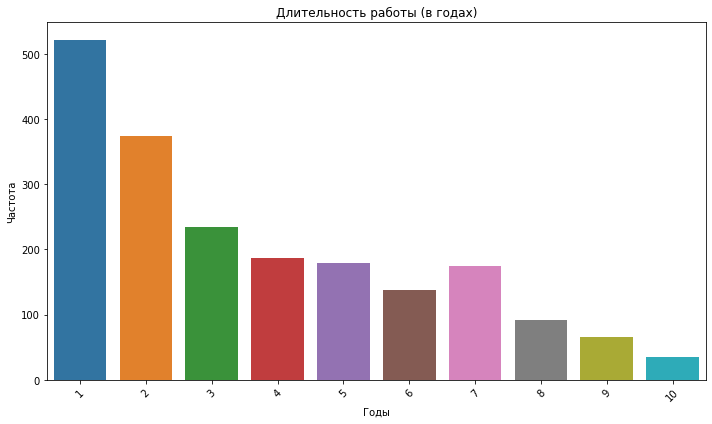

In [148]:
plot_bar_chart(q_test, 'employment_years', 'Длительность работы (в годах)', 'Годы')

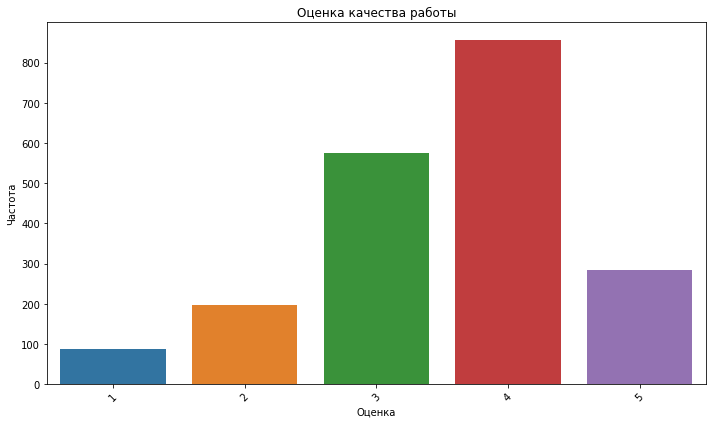

In [149]:
plot_bar_chart(q_test, 'supervisor_evaluation', 'Оценка качества работы', 'Оценка')

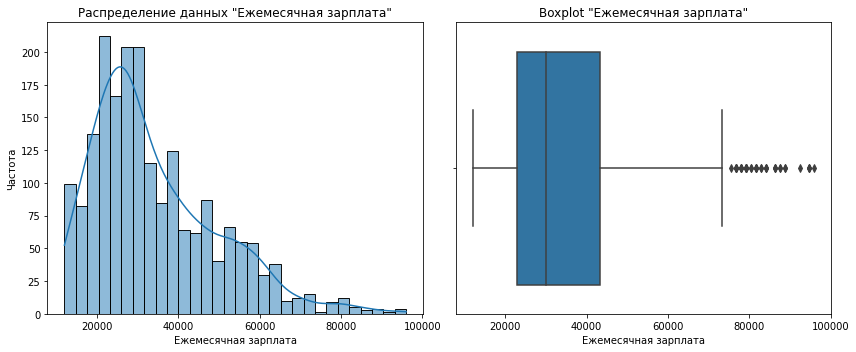

In [150]:
plot_distribution(q_test, 'salary', bins=30, title='Ежемесячная зарплата')

### Целевой признак тестовой выборки

In [151]:
q_test_target['quit'].value_counts(normalize=True)

no     0.718
yes    0.282
Name: quit, dtype: float64

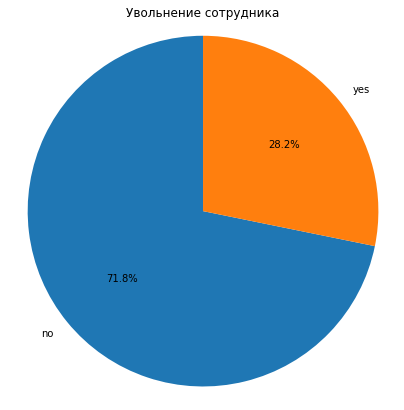

In [152]:
plot_categorical(q_test_target, 'quit', 'Увольнение сотрудника')

### Вывод

Данные очень похожие на те что мы уже видели, но теперь еще знает что 28% сотрудников уволилось.

### Портрет уволившегося сотрудника

In [153]:
# преобразуем quit в бинарный вид для группировки, создадим новый столбец
df = q_train.copy()
df['quit_binary'] = df['quit'].map({'no': 0, 'yes': 1}).astype(int)

In [154]:
# доля увольнений по отделам
df.groupby('dept')['quit_binary'].mean().sort_values(ascending=False)

dept
technology    0.297414
sales         0.283032
purchasing    0.282313
marketing     0.280069
hr            0.250000
Name: quit_binary, dtype: float64

In [155]:
df.groupby('level')['quit_binary'].mean().sort_values(ascending=False)

level
junior    0.514623
middle    0.063754
sinior    0.047619
Name: quit_binary, dtype: float64

In [156]:
df.groupby('workload')['quit_binary'].mean().sort_values(ascending=False)

workload
low       0.429636
medium    0.230406
high      0.179525
Name: quit_binary, dtype: float64

In [157]:
df.groupby('supervisor_evaluation')['quit_binary'].mean().sort_values(ascending=False)

supervisor_evaluation
1    0.470297
3    0.424169
2    0.419437
4    0.172914
5    0.115385
Name: quit_binary, dtype: float64

In [158]:
df.groupby('quit')['salary'].mean()

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64

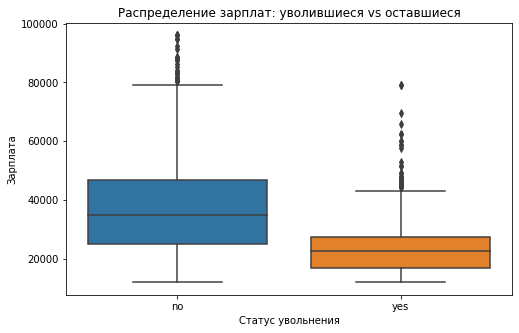

In [159]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='quit', y='salary')
plt.title('Распределение зарплат: уволившиеся vs оставшиеся')
plt.ylabel('Зарплата')
plt.xlabel('Статус увольнения')
plt.show()

In [160]:
df.groupby('quit')['last_year_promo'].value_counts(normalize=True).unstack()

last_year_promo,no,yes
quit,,
no,0.961003,0.038997
yes,0.999113,0.000887


In [161]:
df.groupby('quit')['last_year_violations'].value_counts(normalize=True).unstack()

last_year_violations,no,yes
quit,,
no,0.889624,0.110376
yes,0.797872,0.202128


#### Вывод

Уволившийся сотрудник» — это, скорее всего:
Сотрудник, который работает в отделе technology на уровне junior. с низкой нагруженностью и получающий зарплату ниже средней (30000). Такой сотрудник имеет оценку от руководителя от 1 до 3 (скорее даже 1). У данного сотрудника также не было повышения за последний год и не было нарушений договора.

### Проверка гипотезы 

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

In [162]:
q_test.head(), d_test_target.head(), q_test_target.head()

(       id        dept   level workload  employment_years last_year_promo  \
 0  100298          hr  junior      low                 2              no   
 1  100480   marketing  junior      low                 4              no   
 2  100503  purchasing  middle     high                 5              no   
 3  100610       sales  middle   medium                 5              no   
 4  100692       sales  middle     high                 6              no   
 
   last_year_violations  supervisor_evaluation  salary  
 0                   no                      4   19200  
 1                   no                      4   16800  
 2                   no                      4   55200  
 3                   no                      4   43200  
 4                   no                      4   48000  ,
        id  job_satisfaction_rate
 0  100298                   0.80
 1  100480                   0.84
 2  100503                   0.79
 3  100610                   0.75
 4  100692             

In [163]:
test_full = d_test.copy()
test_full = test_full.merge(d_test_target, on='id', how='left')
test_full = test_full.merge(q_test_target, on='id', how='left')
test_full.head(10)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,100298,hr,junior,low,2,no,no,4,19200,0.80,no
1,100480,marketing,junior,low,4,no,no,4,16800,0.84,no
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
3,100610,sales,middle,medium,5,no,no,4,43200,0.75,no
4,100692,sales,middle,high,6,no,no,4,48000,0.69,no
5,100710,hr,sinior,low,6,no,no,4,27600,0.68,no
6,100894,sales,middle,high,6,no,no,3,56400,0.49,no
7,102102,marketing,junior,medium,3,no,no,4,25200,0.73,no
8,102222,marketing,middle,medium,8,no,no,4,36000,0.66,no
9,102320,sales,middle,high,4,no,no,3,57600,0.26,no


In [164]:
d_test.shape, test_full.shape

((2000, 9), (2000, 11))

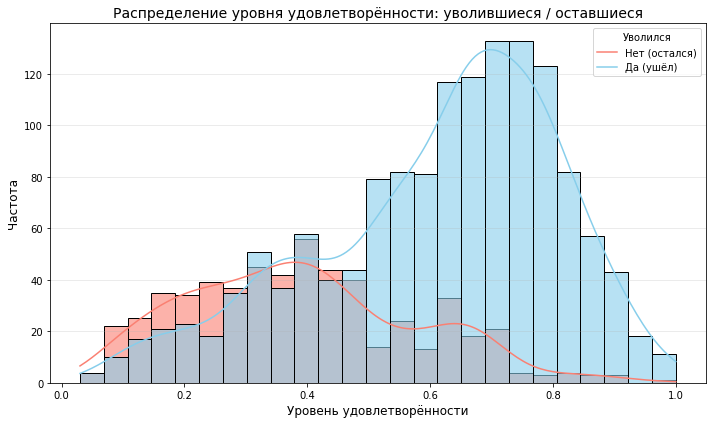

In [165]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=test_full,
    x='job_satisfaction_rate',
    hue='quit',
    bins=25,
    kde=True,                    # линия плотности
    palette={'no': 'skyblue', 'yes': 'salmon'},
    alpha=0.6
)
plt.title('Распределение уровня удовлетворённости: уволившиеся / оставшиеся', fontsize=14)
plt.xlabel('Уровень удовлетворённости', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.legend(title='Уволился', labels=['Нет (остался)', 'Да (ушёл)'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [166]:
mean_by_quit = test_full.groupby('quit')['job_satisfaction_rate'].mean()
print("Средний уровень удовлетворённости:")
print(mean_by_quit.round(2))

median_by_quit = test_full.groupby('quit')['job_satisfaction_rate'].median()
print("\nМедианный уровень удовлетворённости:")
print(median_by_quit.round(2))

count_by_quit = test_full['quit'].value_counts()
print("\nКоличество сотрудников:")
print(count_by_quit)

Средний уровень удовлетворённости:
quit
no     0.61
yes    0.39
Name: job_satisfaction_rate, dtype: float64

Медианный уровень удовлетворённости:
quit
no     0.66
yes    0.37
Name: job_satisfaction_rate, dtype: float64

Количество сотрудников:
no     1436
yes     564
Name: quit, dtype: int64


#### Вывод

На графике видно, что:
1. У оставшихся пик смещён вправо (высокая удовлетворенность),
2. У ушедших — влево (низкая удовлетворенность).

Средний уровень удовлетворенности уволившегося сотрудника до 0,4, когда у оставшихся 0,61-0,66. Разница значительная. Это и показатель графика дает понять, что аналитики правы уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

## Добавление нового входного признака

In [167]:
q_train_new = q_train.copy()
q_train_new['job_satisfaction_pred'] = best_model.predict(X_train)
q_train_new.head(10), q_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   quit                   4000 non-null   object 
 10  job_satisfaction_pred  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB


(       id        dept   level workload  employment_years last_year_promo  \
 0  723290       sales  middle     high                 2              no   
 1  814010       sales  junior   medium                 2              no   
 2  155091  purchasing  middle   medium                 5              no   
 3  257132       sales  junior   medium                 2              no   
 4  910140   marketing  junior   medium                 2              no   
 5  699916       sales  junior      low                 1              no   
 6  417070  technology  middle   medium                 8              no   
 7  165489       sales  middle      low                 4              no   
 8  996399   marketing  middle      low                 7              no   
 9  613206  technology  middle   medium                 2              no   
 
   last_year_violations  supervisor_evaluation  salary quit  \
 0                   no                      4   54000   no   
 1                   no  

## Подготовка данных и обучение модели

In [168]:
X_train_1 = q_train_new.drop(columns=['id', 'quit'])
y_train_1 = q_train_new['quit']

col_num_1 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_pred']

In [169]:
# создаём препроцессор
preprocessor_1 = ColumnTransformer([
    ('cat_ohe', ohe_pipeline, col_ohe),
    ('cat_ord', ord_pipeline, col_ord),
    ('num', RobustScaler(), col_num_1)
], remainder='drop')  # на всякий случай, если что-то осталось

preprocessor

ColumnTransformer(transformers=[('cat_ohe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['dept']),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'sinior'],
                                                                             ['low',
     

In [170]:
final_pipeline = Pipeline([
    ('clean_spaces', FunctionTransformer(clean_spaces)),
    ('preprocessor', preprocessor_1),
    ('classifier', 'passthrough')
])
# параметры
param_grid_1 = [
    # KNN
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7, 9, 11, 13],
        'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    # Decision Tree
    {
        'classifier': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'classifier__max_depth': [3, 5, 7, 10, None],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    # Logistic Regression
    {
        'classifier': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)],
        'classifier__C': np.logspace(-3, 3, 7),  # [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__penalty': ['l1', 'l2']
    },
    # SVC
    {
        'classifier': [SVC(random_state=RANDOM_STATE, probability=True)],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['rbf', 'linear', 'poly'],
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
]

In [171]:
search = RandomizedSearchCV(
    final_pipeline,
    param_grid_1,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
search.fit(X_train_1, y_train_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('clean_spaces',
                                              FunctionTransformer(func=<function clean_spaces at 0x7f17794ed9d0>)),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('cat_ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['dept']),
                                                                    

In [172]:
print("Лучшая модель:", search.best_estimator_)
print("Лучший ROC-AUC:", search.best_score_.round(4))

Лучшая модель: Pipeline(steps=[('clean_spaces',
                 FunctionTransformer(func=<function clean_spaces at 0x7f17794ed9d0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat_ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('cat_ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most...
                                                                                  handle_unknown='use

In [173]:
test_X = test_full.drop(columns=['id', 'quit'])
test_X = test_X.rename(columns={'job_satisfaction_rate': 'job_satisfaction_pred'})
test_y = test_full['quit']

best_model_1 = search.best_estimator_

y_pred_test = best_model_1.predict_proba(test_X)[:, 1]
roc_auc_test = roc_auc_score(test_y, y_pred_test)
roc_auc_test

0.9216857800430668

### Вывод

Лучше всего себя показала модель: метод опорных векторов (SVC). Причина увольнения неленейна и состоит из множества факторов, поэтому данная модель справилась лучше всего. Сильно помог параметр удовлетворенности.

# Общий вывод

## Задача 1: предсказание уровня удовлетворённости сотрудника

1. Загрузили таблицы, они соответствовали описанию.
2. Сменили типы данных в колонках, чтобы было легче. Обнаружили пропуски, которые обработали в пайплайне.
3. Исследовали данные:

Матрица корреляций показала следующие основные связи:
- Сильная положительная корреляция между Supervisor Evaluation (оценка руководителем) и Job Satisfaction Rate (оценка удовлектворенности), коэффициент 0.69. Это указывает на то, что высокая оценка от руководителя существенно повышает удовлетворённость.
- Умеренная положительная корреляция между Employment Years (стаж работы) и Job Satisfaction Rate (оценка удовлектворенности), коэффициент 0.46. Сотрудники с большим стажем, как правило, демонстрируют более высокий уровень удовлетворённости, но эта связь не является чёткой.

Общее

Линейная связь частично присутствует (особенно между оценкой руководителем и удовлетворённостью), но данные содержат много нелинейностей и категориальных факторов. Линейная регрессия подойдёт как базовая модель, но лучше использовать дерево решений для более точного и адекватного прогноза.
4. Подготовили данные и обучили 2 модели.

На тренировочной выборке  показала себя лучше модель DecisionTreeRegressor и на тестовой выборке достигла критерия успеха (SMAPE: 13,5 ≤ 15). Линейная модель не может эффективно работать, т.к. слабая линейная связь в данных. Рекомендуется использовать best_model: DecisionTreeRegressor с параметрами:
- 'regressor__max_depth': None,
- 'regressor__min_samples_leaf': 4,
- 'regressor__min_samples_split': 10.

Если заполнить средним, метрика хуже, модель прошла адекватность.

## Задача 2: предсказание увольнения сотрудника из компании

1. Загрузили таблицы, они соответствовали описанию.
2. Сменили типы данных в колонках, чтобы было легче. Обнаружили пропуски, которые обработали в пайплайне.
3. Исследовали данные:
- Портрет уволившегося сотрудника: Уволившийся сотрудник» — это, скорее всего: cотрудник, который работает в отделе technology на уровне junior. с низкой нагруженностью и получающий зарплату ниже средней (30000). Такой сотрудник имеет оценку от руководителя от 1 до 3 (скорее даже 1). У данного сотрудника также не было повышения за последний год и не было нарушений договора.
- Проверили гипотезу: "Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник."

На графике видно, что:

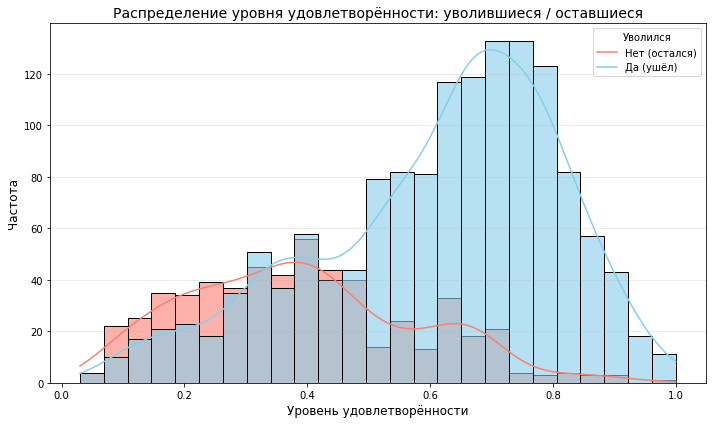

У оставшихся пик смещён вправо (высокая удовлетворенность), у ушедших — влево (низкая удовлетворенность). Средний уровень удовлетворенности уволившегося сотрудника до 0,4, когда у оставшихся 0,61-0,66. Разница значительная. Это и показатель графика дает понять, что аналитики правы уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

4. Подготовили данные и обучили 3 модели.

Добавили в исходные данные предсказания модели первой задачи, а именно удовлетворенность сотрудников. Лучше всего себя показала модель: метод опорных векторов (SVC). Причина увольнения неленейна и состоит из множества факторов, поэтому данная модель справилась лучше всего. Сильно помог параметр удовлетворенности.

## Рекомендации

1. Следите за уровнем удовлетворенности сотрудников, сотрудники с низким уровнем увольняются чаще (особенно на старте карьеры в компании - уровень junior).
2. Обратите внимание на сотрудников с низкой загруженности.
3. Внедрите ясные карьерные пути и их критерии достижения для всех должностей.